# Introduction

## Imports

In [1]:
import functools

import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as scint

xr.set_options(keep_attrs=True)

## Physical Constants

In [2]:
c = 299792458  # m/s
kB = 1.38064852E-23  # (m^2 kg) / (s^2 K)
e_charge = 1.60217662E-19  # coulombs
eps_0 = 8.854187E-12  # F/m
m_electron = 9.109E-31  # kg

## Common Values

In [3]:
lambda_355 = 355E-9  # m
lambda_118 = lambda_355/3  # m

def lambda_to_freq(lamb):
    return c/lamb

def freq_to_lambda(freq):
    return c/freq

omega_355 = lambda_to_freq(lambda_355)
omega_118 = omega_355*3  # Hz

mXe = 2.1801714E-25  # kg

# Experimental Data

Our experimental data ... (background)

We can load the experimental data:

In [4]:
exp_data_path = "../data/experimental/"
col_names = ["PXe", "Fluor", "Fluor_Err", "Sig_118", "Sig_118_Err"]
exp_data_Ar = pd.read_csv(exp_data_path + "ArDat.csv", header=0, names=col_names)
exp_data_Kr = pd.read_csv(exp_data_path + "KrDat.csv", header=0, names=col_names)

exp_data = pd.concat([exp_data_Ar, exp_data_Kr], keys = ['Ar', 'Kr'])
exp_data

PXe    Fluor  Fluor_Err    Sig_118  Sig_118_Err
Ar 0   73.54443  0.73473   0.006770    6.11362      0.51245
   1   69.45863  0.72196   0.004530   10.34578      0.66929
   2   65.37283  0.68439   0.007350   18.62638      0.94510
   3   61.28703  0.62836   0.009370   32.21405      0.82459
   4   57.20123  0.57683   0.020310   52.69991      1.74752
   5   53.11542  0.53410   0.013610   86.77434      2.39953
   6   49.02962  0.44454   0.013670  134.67013      2.28278
   7   44.94382  0.40832   0.008570  192.47936      5.90638
   8   40.85802  0.34731   0.008210  270.02981      6.70529
   9   36.77222  0.25689   0.008490  343.52629      9.64824
   10  32.68641  0.19149   0.007250  419.99166     14.01780
   11  28.60061  0.12986   0.004720  474.07065     13.76460
   12  24.51481  0.07787   0.001780  497.83225     21.59864
   13  20.42901  0.02992   0.000962  466.56067     23.11341
   14  16.34321  0.00581   0.000173  354.88712     20.80868
   15  12.25741  0.01411   0.000575  239.68669     18.46285
   16   8.17160  0.00789   0.000275   97.39048      6.43226
   17   4.08580  0.00855   0.000284    9.86240      0.84662
   18   0.00000  0.01291   0.000438    2.92345      0.29524
Kr 0   74.68108  0.63775   0.009870    0.97741      0.06530
   1   69.18919  0.57687   0.010600    1.03222      0.07559
   2   63.78378  0.50766   0.009930    1.02871      0.06850
   3   58.37838  0.44815   0.011680    1.31625      0.09285
   4   52.97297  0.37168   0.008620    2.31317      0.12491
   5   47.56757  0.29239   0.006780    7.53936      0.28347
   6   42.16216  0.21594   0.006190   18.62682      0.52842
   7   36.75676  0.15307   0.004140   42.18585      1.10781
   8   31.35135  0.09868   0.002010   86.20923      1.85430
   9   25.94595  0.04751   0.001170  144.71971      3.36445
   10  20.54054  0.01942   0.000595  202.58454      4.89065
   11  15.13514  0.01715   0.000598  218.00416      8.97809
   12   9.72973  0.01000   0.000295  150.03862      7.43832
   13   4.32432  0.00667   0.000160   26.18145      2.33166
   14   0.00000  0.00885   0.000346    1.04523      0.08485

The values for the signal and fluorescence are arbitrary. We can normalize the data so that we can plot the two experimental runs side-by-side. We have to take care though, while the scaling is arbitrary, the scaling between the argon and krypton data is meaningful.

In [5]:
peak_118_signal = max(exp_data.Sig_118)
peak_fluor = max(exp_data.Fluor)

fluors = ["Fluor", "Fluor_Err"]
sig_118s = ["Sig_118", "Sig_118_Err"]

exp_data[sig_118s] = exp_data[sig_118s] / peak_118_signal
exp_data[fluors] = exp_data[fluors] / peak_fluor

exp_data.head()

PXe     Fluor  Fluor_Err   Sig_118  Sig_118_Err
Ar 0  73.54443  1.000000   0.009214  0.012280     0.001029
   1  69.45863  0.982619   0.006166  0.020782     0.001344
   2  65.37283  0.931485   0.010004  0.037415     0.001898
   3  61.28703  0.855226   0.012753  0.064709     0.001656
   4  57.20123  0.785091   0.027643  0.105859     0.003510

We can now plot the data:

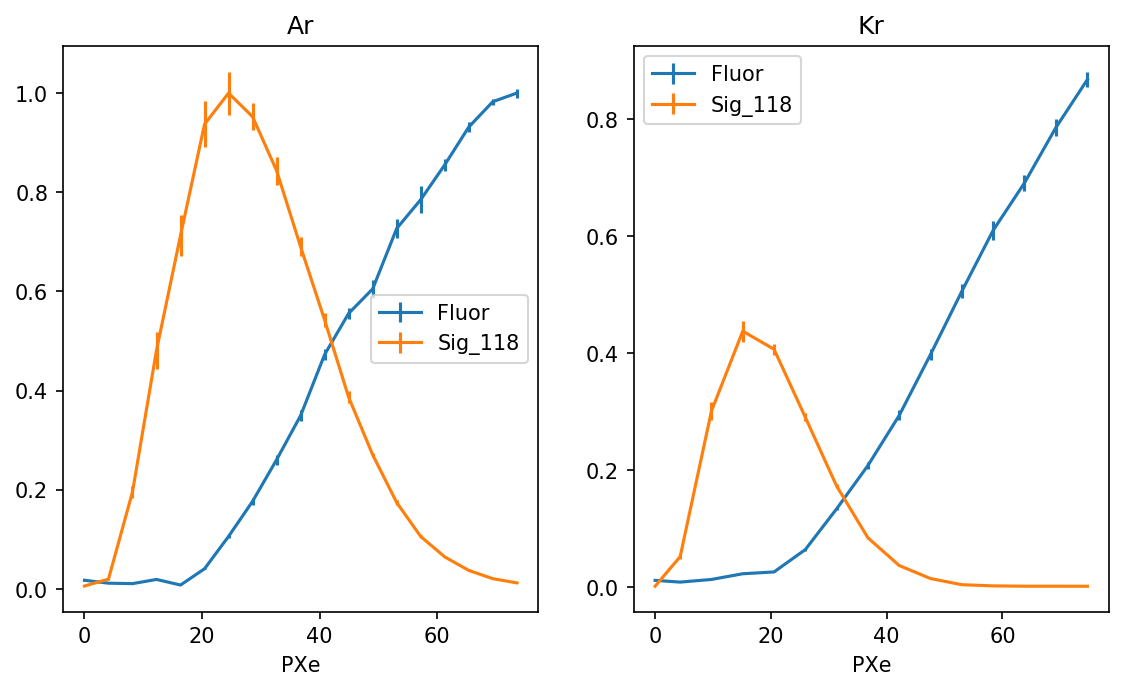

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(9,5), dpi=150)

plot_params = [(exp_data.loc['Ar'], ax[0], 'Ar'), 
               (exp_data.loc['Kr'], ax[1], 'Kr')]

for data, ax, title in plot_params:
    data.plot(x='PXe', y='Fluor', yerr='Fluor_Err', ax=ax)
    data.plot(x='PXe', y='Sig_118', yerr='Sig_118_Err', ax=ax)
    ax.set_title(title)

We immediately notice that the krypton peak is lower than the argon peak, and is shifted towards lower pressures.

# 1D Propagation Model

We need a model that allows us to explore some of the dynamics that we think are occuring. One way to look at this is through a beam propagation model. We can solve a differential equation as a function of distance in the longitudinal direction to see how the intensity of the 118 nm beam increases and then decreases.

## Beam Parameters

These are parameter measured from our experimental setup.

In [7]:
b = 0.023      # [m] Confocal parameter taken from 118 OH paper
zR = b / 2     # [m] Rayleigh Range
omega0 = np.sqrt(lambda_355 * zR / np.pi) # [m] Beam radius at the focus

## Beam Functions

In [8]:
def beam_radius(z, params):
    """
    Return the radius of a Gaussian beam a distance z from the focus.
    Parameters:
        z       - Required : distance from beam focus (float) [m]
        params  - Required : parameter list (Dict[str:float])
            "omega0" : beam waist at focus (float) [m]
            "zR" : rayleigh range of the gaussian beam (float) [m]
    
    Returns:
        radius of the gaussian beam at distance z (float) [m]
    
    """
    
    omega0 = params['omega0']
    zR = params['zR']
    # [m] * sqrt(1 + ([m]/[m])^2) = [m]
    return omega0 * np.sqrt(1+(z/zR)**2)

def dBeam_radius_dz(z, params):
    """
    Return the derivative of the beam radius with respect to z.
    Parameters:
        z       - Required : distance from beam focus (float) [m]
        params  - Required : parameter list (Dict[str:float])
            "omega0" : beam waist at focus (float) [m]
            "zR" : rayleigh range of the gaussian beam (float) [m]
    
    Returns:
        rate of change of the radius of the gaussian beam with
        respect to z (float) [m/m]
    
    """
    
    omega0 = params['omega0']
    zR = params['zR']
    # [m] * ([m] / [m]^2) / sqrt(1 + ([m]/[m])^2) = 1 ([m]/[m])
    return omega0 * (z/(zR**2)) / np.sqrt(1+(z/zR)**2)

def peak_intensity_355(params):
    """
    Return the peak intensity of the 355 nm pulse.
    Parameters:
        params  - Required : parameter list (Dict[str:float])
            "omega0" : beam waist at focus (float) [m]
            "energy" : energy in one pulse of the laser (float) [J]
            "duration" : FWHM length of a laser pulse (float) [s]
    
    Returns:
        peak irradiance of the 355 pump beam (float) [J/(m^2 s), W/m^2]
    
    """
    
    omega0 = params['omega0']
    energy = params['energy']
    duration = params['duration']
    # [J] / (([m]^2) * [s]) = [W/m^2]
    return energy / ((np.pi * omega0**2) * duration)

def peak_amplitude_355(params):
    """
    Return the peak electric field amplitude of the 355 nm pulse.
    Parameters:
        params  - Required : parameter list (Dict[str:float])
            "omega0" : beam waist at focus (float) [m]
            "energy" : energy in one pulse of the laser (float) [J]
            "duration" : FWHM length of a laser pulse (float) [s]

    Returns:
    
    """
    
    return np.sqrt(2*peak_intensity_355(params) / (c * eps_0))
    
def amplitude_355(z, params):
    """
    Return the profile of the 355 nm beam amplitude as a function of z.
    Parameters:
    
    
    Returns:
    
    """
    omega0 = params['omega0']
    return peak_amplitude_355(params) * (np.pi * omega0**2) / \
            (np.pi * beam_radius(z, params)**2)
            
def dAmplitude_355_dz(z, params):
    """
    Return the derivative of the 355 beam waist.
    Parameters:
    
    
    Returns:
    
    """
    omega0 = params['omega0']
    return peak_amplitude_355(params) * (np.pi * omega0**2) * \
        1/np.pi * -2 * dBeam_radius_dz(z, params) / \
        (beam_radius(z, params)**3)

## Differential Equations

We have a few different models that we are interested in. We can easily switchh between which models we are looking at by wrapping each differential equation in a larger function that unwraps the necessary parameters and has the differential equation step.

### 2-Photon Harmonic Generation Process


The two-photon harmonic generation process occurs when a 118 nm photon and a 355 nm photon combine through harmonic generation in the phase-matching gas (argon or krypton). This results in an 88 nm photon which then has enough energy to immediately ionize the xenon atoms in the gas mixture. The process of generating the 88 nm photons relies linearly on the pressure of the mixing gas, which is proportional to the pressure of xenon, so we can just call it linear with respect to the xenon pressure and then absorb the proportionality constant into the nonlinear constant for this process. The mathematical models is then:

$$\frac{dA_{118}}{dz} = \chi^{(3)}N_{Xe}k_{118}A_{355}^3 - \chi^{(2)} N_{Xe} k_{88} A_{118} A_{355}$$

In [9]:
def dAmplitudes_dz_2_photon(z, amplitudes, params):
    """
    Return the rate of change of the amplitudes of the 355, 118, and 88 light.
    
    This function works on all three at the same time so that the function works
    with the scipy integrator.
    
    Loss = -sigma * PXe * A118 * A355
    
    Parameters:
    
    
    Returns:
    
    """
    chi3 = params['chi3']
    chi2 = params['sigma']
    PXe = params['PXe'] * 3.54e16
    
    k118 = 2*np.pi/(118e-9)
    k88 = 2*np.pi/(88e-9)
        
    [A_355, A_118, _] = amplitudes
        
    dA_355_dz = dAmplitude_355_dz(z, params)
    dA_118_dz = chi3*PXe*k118 * A_355**3 - chi2 * PXe * k88 * A_118 * A_355
    dA_fluo_dz = chi2*PXe*k88 * A_118**2 * A_355
        
    return [dA_355_dz, dA_118_dz, dA_fluo_dz]

### Sudo first-order 1+1' REMPI Process with saturated 355 

The pseudo-first order 1+1' REMPI process is the process described previously in the linear absorption notebook. A 118 nm photon is absorped by a xenon atom into either the 7s or 5d transition, and then the excited atom immediately interacts with a 355 nm photon and ionizes. The loss on this process is Beer's Law in action.

$$\frac{dA_{118}}{dz} = \chi^{(3)}N_{Xe}k_{118}A_{355}^3 - \frac{1}{2}\sigma_{linear}N_{Xe}^2A_{118}$$

In [10]:
def dAmplitudes_dz_1p1_REMPI(z, amplitudes, params):
    """
    
    Loss = -sigma * PXe^2 * A118
    
    """
    chi3 = params['chi3']
    sigma = params['sigma']
    PXe = params['PXe'] * 3.54e16
    
    k118 = 2*np.pi/(118*10**(-9))
    
    [A_355, A_118, _] = amplitudes
    dA_355_dz = dAmplitude_355_dz(z, params)
    dA_118_dz = chi3*PXe*k118 * A_355**3 - sigma * PXe**2 * A_118
    dA_fluo_dz = 0.5*sigma * PXe**2 * A_118 
    
    return [dA_355_dz, dA_118_dz, dA_fluo_dz]

### 1+1' REMPI Process

In [11]:
def dAmplitudes_dz_1p1_REMPI_355(z, amplitudes, params):
    """
    
    Loss = -sigma * PXe^2 * A118 * 355
    
    """
    chi3 = params['chi3']
    sigma = params['sigma']
    PXe = params['PXe'] * 3.54e16
    
    k118 = 2*np.pi/(118*10**(-9))
    
    [A_355, A_118, _] = amplitudes
    dA_355_dz = dAmplitude_355_dz(z, params)
    dA_118_dz = chi3*PXe*k118 * A_355**3 - sigma * PXe**2 * A_118 * A_355
    dA_fluo_dz = 0.5*sigma * PXe**2 * A_118 * A_355
    
    return [dA_355_dz, dA_118_dz, dA_fluo_dz]

In [12]:
diff_eqs = {"dAmplitudes_dz_2_photon": dAmplitudes_dz_2_photon,
            "dAmplitudes_dz_1p1_REMPI": dAmplitudes_dz_1p1_REMPI,
            "dAmplitudes_dz_1p1_REMPI_355": dAmplitudes_dz_1p1_REMPI_355}

### Basic Solving

We can solve a single differential equation to see what the intensity of the beams looks like as a function of longitudinal distance.

First we set up all of our parameters:

In [13]:
func = dAmplitudes_dz_2_photon
#func = dAmplitudes_dz_1p1_REMPI
#func = dAmplitudes_dz_1p1_REMPI_355

PXe = 25

chi2 = 1.5e-33 # [Units?]
chi3 = 1.5e-44   # [Units?]
sigma_1p1 = 6.3E-37
sigma_1p1_355 = 1.6E-43    
    

pulse_params = {'b' : b,            # [m] confocal parameter
                   'zR' : zR,           # [m] Rayleigh range
                   'omega0' : omega0,   # [m] beam waist at focus
                   'energy' : 0.017,       # [J] single pulse energy
                   'duration' : 7e-9}     # [s] single pulse length

harm_params = {'sigma' : chi2,
               'chi3' : chi3,
               'PXe' : PXe,
               'sigma_1p1' : sigma_1p1,
               'sigma_1p1_355' : sigma_1p1_355,
               }

In [14]:
nonzero = 1e-10
params = {**pulse_params, **harm_params}
initial_vals = (nonzero, nonzero, nonzero)

zstart = -0.2
zstop = 0.2
zrange = (zstart, zstop)
plotrange = (-0.08, 0.08)
z = np.array(np.linspace(zstart, zstop, 1000))
dz = z[1] - z[0]

We can then build a function that reads in all of the parameters, solves the differential equation, and then bundles the result into an xarray DataSet. Having the data in a DataSet gives us a range of convenient, automatic plotting options. More importantly, it allows us to attachh all of the metadata that generated that dataset. This hhelps to ensure that we can trace back the results of each simulation to the important physical parameters that we care about.

In [15]:
def solve_diff_eq(func, params, zrange, init_vals, t_eval):
    
    sol = scint.solve_ivp(functools.partial(func, params=params), 
                          zrange, init_vals, t_eval=t_eval)
    
    # package into an xarray
    beam_355 = xr.DataArray(sol['y'][0], 
                            dims = ('z'), 
                            coords = {'z': sol['t']},
                            attrs = {'units': 'V/m',
                                     'long_name': "355 nm amplitude"})
    beam_118 = xr.DataArray(sol['y'][1], 
                            dims = ('z'), 
                            coords = {'z': sol['t']},
                            attrs = {'units': 'V/m',
                                     'long_name': "118 nm amplitude"})
    fluor = xr.DataArray(sol['y'][2], 
                            dims = ('z'), 
                            coords = {'z': sol['t']},
                            attrs = {'units': 'arb.',
                                     'long_name': "Fluorescence"})
    
    data = xr.Dataset(
        data_vars = {'beam_355': beam_355,
                     'beam_118': beam_118,
                     'fluor': fluor},
        attrs = {'z_range': zrange, 'init_vals': init_vals, **params}
        )
    return data
    
data = solve_diff_eq(func, params, zrange, initial_vals, z)

Finally, we can plot the results.

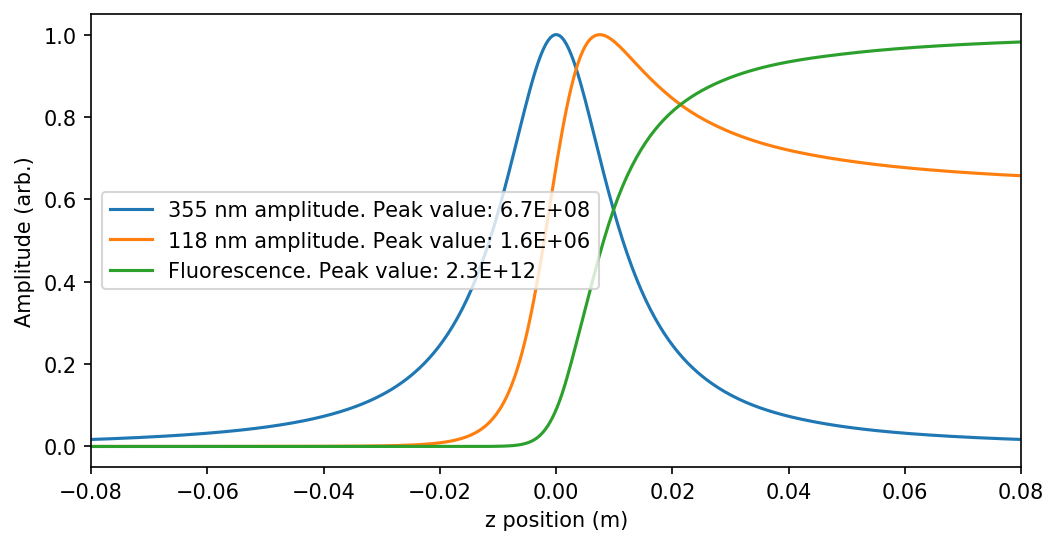

In [16]:
dat = [data.beam_355, data.beam_118, data.fluor]

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)

for d in dat:
    ax.plot(d.z, d/max(d), 
            label=f"{d.attrs['long_name']}. Peak value: {max(d).data:.2G}")
    
ax.set_xlim([-0.08, 0.08])
#ax.set_ylim([.6, 1.05])
ax.set_xlabel('z position (m)')
ax.set_ylabel('Amplitude (arb.)')
plt.legend()
plt.show()

Quick Analysis

## Scanning Variables

### Helper Functions

This can be generalized so that we feed in DataArrays for te scan variables, and it automatically scans and labels the output dataset accordingly.

In [17]:
def scan_parameter_1D_ODE(param_scan_func, params, scan_range):
    """
    param_scan_func: A function of the form 'func(params)'. The function
        should return a well-formed DataArray
    scan_range: DataArray of scan variable
    
    
    """
    
    scan_in_params = scan_range.dims[0] in params
    if not scan_in_params:
        raise KeyError("Scan parameter is not in parameter list.")
        
    new_data = []    
    for param_val in scan_range.data:
        params[scan_range.dims[0]] = param_val
        new_data.append(param_scan_func(params=params))
    
    old_coords = list(new_data[0].dims)
    new_coords = [scan_range] + [new_data[0].coords[key] for key in old_coords]
    new_xr = xr.DataArray(new_data, coords=new_coords)
    
    scanned_params = old_coords + [scan_range.dims[0]]
    unscanned_params = {key: params[key] 
                        for key in params 
                        if key not in scanned_params}
    
    new_xr.attrs = {**unscanned_params, **new_data[0].attrs}
    
    return new_xr

It is useful to have a function to take in a a scan of the amplitudes as a function of $z$, and convert it to something similar to what we would measure in the experiment. In this case, the amplitude of 118 nm light at the end of the simulation, and the summed intensity of the fluorescence through some range near the middle of the simulation.

In [18]:
def calc_118_and_fluor(params, zrange, init_vals, t_eval):
    """
    
    
    """
    func = diff_eqs[params["func"]]
    data = solve_diff_eq(func, params, zrange, initial_vals, z)
    
    detected_118 = data.beam_118[-1]**2
    
    fluor_low, fluor_high = params['fluor_detect_window']
    in_window = ((t_eval>=fluor_low) * (t_eval<=fluor_high)).astype(int)
    fluorescence = sum((data.fluor*in_window)**2)
    
    result = xr.DataArray([detected_118.data, fluorescence.data],
                         dims='variable',
                         coords={'variable': ['118 signal', 'Fluorescence signal']},
                         attrs={'units': 'Arb.',
                                'zrange': zrange,
                                'init_vals': init_vals,
                                't_eval': t_eval,
                                'func': func.__name__})
    return result

Finally, we can write a little scan builder function that takes in all of the scans that we would like to run, and repeatedly curries them down to a single function that only needs a parameter to run. Combined with the ability of `scan_parameter_1D_ODE` to continuously add layers to its data model, this function allows us to specify $N$ variables to scan, and the receive an $N$-dimensional output array.

In [19]:
def scan_builder(func, params, scans):
    """
    func: func(params)
    params: dict of params
    scans: list of DataArrays to scan.
    
    """
    
    for scan in scans:
        func = functools.partial(scan_parameter_1D_ODE,
                                 param_scan_func=func,
                                 scan_range=scan)
    return func

### Test Run

This shows the general structure of how to simulate 118 nm light generation, propagation, and loss. First we specify the parameters that we want to run with.

In [20]:
params = {'b' : b,            # [m] confocal parameter
          'zR' : zR,           # [m] Rayleigh range
          'omega0' : omega0,   # [m] beam waist at focus
          'energy' : 0.017,       # [J] single pulse energy
          'duration' : 7e-9,     # [s] single pulse length

          'sigma' : chi2,
          'chi3' : chi3,
          'PXe' : PXe,
          'sigma_1p1' : sigma_1p1,
          'sigma_1p1_355' : sigma_1p1_355,

          'fluor_detect_window': (-0.1, 0.1),
          'func': "dAmplitudes_dz_2_photon"
          }

Then, we specify the variables that we want to scan over. Note the value assigned to the `dims` keyword must exactly match one of the parameters in the `params`. Otherwise the function won't know what variable it is supposed to scan.

In [21]:
zsamples = 100
zrange = (-.2, .2)
z = np.array(np.linspace(zrange[0], zrange[1], zsamples))

Psamples = 100
Prange = (1, 80) # [Torr]
PXe = np.linspace(Prange[0], Prange[1], Psamples)
Pscan = xr.DataArray(PXe, 
                     dims = ('PXe'), 
                     attrs = {'units': 'Torr',
                              'long_name': "Partial Pressure of Xenon"})

Esamples = 6
Erange = (0.002, 0.022) # [J] of 355 pump power
Es = np.linspace(Erange[0], Erange[1], Esamples)
Escan = xr.DataArray(Es,
                     dims = ('energy'),
                     attrs = {'units': 'J',
                              'long_name': "Pump laser pulse energy"})

bsamples = 3
brange = (0.013, 0.033) # [J] of 355 pump power
bs = np.linspace(brange[0], brange[1], bsamples)
bscan = xr.DataArray(bs,
                     dims = ('b'),
                     attrs = {'units': 'm',
                              'long_name': "Confocal parameter"})

funcscan = xr.DataArray(["dAmplitudes_dz_2_photon",
                         "dAmplitudes_dz_1p1_REMPI",
                         "dAmplitudes_dz_1p1_REMPI_355"],
                     dims = ('func'),
                     attrs = {'units': 'function',
                              'long_name': "ODE"})

Finally, we build and run the scan!

In [22]:
single_func = functools.partial(calc_118_and_fluor,
                                zrange=zrange,
                                init_vals=[1e-10,1e-10,1e-10],
                                t_eval=z)

scan = scan_builder(single_func, params, [Pscan, Escan, bscan])

In [23]:
scanned = scan(params=params)

### Results

The resulting object has a useful set of attributes. We can see the coordinates that were scanned by looking at the `coords` variable. This lets us easily verify that the data is what we thing it should be. It also lets us build axes for plotting very easily.

We can also look at the `attrs` variable, which shows us all of the attributes of the scan. This is all of the initial data that went innto making the data file. No more trying to remember what parameters created which object! The parameters are now bundled with the object itself.

In [24]:
print(scanned.coords)

Coordinates:
  * b         (b) float64 0.013 0.023 0.033
  * energy    (energy) float64 0.002 0.006 0.01 0.014 0.018 0.022
  * PXe       (PXe) float64 1.0 1.798 2.596 3.394 4.192 ... 77.61 78.4 79.2 80.0
  * variable  (variable) <U19 '118 signal' 'Fluorescence signal'


In [25]:
scanned.attrs

{'zR': 0.0115,
 'omega0': 3.604857986586053e-05,
 'duration': 7e-09,
 'sigma': 1.5e-33,
 'chi3': 1.5e-44,
 'sigma_1p1': 6.3e-37,
 'sigma_1p1_355': 1.6e-43,
 'fluor_detect_window': (-0.1, 0.1),
 'func': 'dAmplitudes_dz_2_photon',
 'b': 0.013,
 'energy': 0.002,
 'units': 'Arb.',
 'zrange': (-0.2, 0.2),
 'init_vals': [1e-10, 1e-10, 1e-10],
 't_eval': array([-0.2       , -0.1959596 , -0.19191919, -0.18787879, -0.18383838,
        -0.17979798, -0.17575758, -0.17171717, -0.16767677, -0.16363636,
        -0.15959596, -0.15555556, -0.15151515, -0.14747475, -0.14343434,
        -0.13939394, -0.13535354, -0.13131313, -0.12727273, -0.12323232,
        -0.11919192, -0.11515152, -0.11111111, -0.10707071, -0.1030303 ,
        -0.0989899 , -0.09494949, -0.09090909, -0.08686869, -0.08282828,
        -0.07878788, -0.07474747, -0.07070707, -0.06666667, -0.06262626,
        -0.05858586, -0.05454545, -0.05050505, -0.04646465, -0.04242424,
        -0.03838384, -0.03434343, -0.03030303, -0.02626263, -0.0222

In [26]:
def norm_DataArray(dataarray, val=None):
    """
    Normalize the input dataarray against itself, or to another value if specified.
    """
    if val is None:
        return dataarray / np.max(dataarray)
    else:
        return dataarray / val

We can then plot the data. As we saw above, when we looked at the `coords` of the data, there are four coordinates, which indicates that this is a 4 dimensional data set. We can really only visualize a couple coordinates at a time, so we fix the values of some coordinates with the `sel` function, and plot the rest.

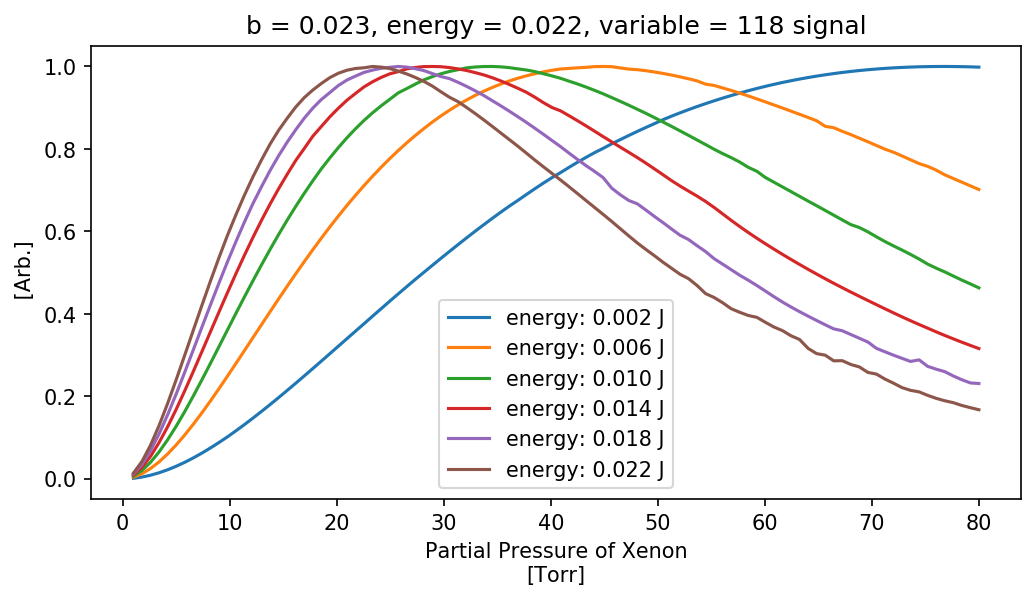

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)

scan_var = 'energy'

for val in scanned.coords[scan_var]:
    label = f"{scan_var}: {val.data:.3F} {val.attrs['units']}"
    data_selection = {'variable': '118 signal', 
                      'energy': val, 
                      'b': 0.023}
    norm_DataArray(scanned.sel(data_selection)).plot(ax=ax, label=label)
ax.legend()

## Single-Variable Analysis

We are just going to run down the parameter list and vary one parameter along with pressure and see what we get.

In [28]:
default_params = {'b' : b,            # [m] confocal parameter
                  'zR' : zR,           # [m] Rayleigh range
                  'omega0' : omega0,   # [m] beam waist at focus
                  'energy' : 0.017,       # [J] single pulse energy
                  'duration' : 7e-9,     # [s] single pulse length

                  'sigma' : chi2,
                  'chi3' : chi3,
                  'PXe' : PXe,
                  'sigma_1p1' : sigma_1p1,
                  'sigma_1p1_355' : sigma_1p1_355,

                  'fluor_detect_window': (-0.1, 0.1),
                  'func': "dAmplitudes_dz_2_photon"
                  }

PXe = np.linspace(1, 200, 200)
Pscan = xr.DataArray(PXe, 
                     dims = ('PXe'), 
                     attrs = {'units': 'Torr',
                              'long_name': "Partial Pressure of Xenon"})

In [29]:
def plot_single_1D_scan(data, ax, selections=None, norm=True):
    scan_var = data.dims[0]
    
    for val in data.coords[scan_var]:
        label = f"{scan_var}: {val.data:.2E} {val.attrs['units']}"
        sel = {scan_var: val, **selections}
        if norm:
            norm_DataArray(data.sel(sel)).plot(ax=ax, label=label)
        else:
            data.sel(sel).plot(ax=ax, label=label)
    ax.set_title(f"Scanning: {scan_var}")
    ax.legend()

In [30]:
bs = np.linspace(0.0115, 0.046, 4)
b_scan = xr.DataArray(bs,
                     dims = ('b'),
                     attrs = {'units': 'm',
                              'long_name': "Confocal parameter"})
b_scanned = scan_builder(single_func, default_params.copy(), [Pscan, b_scan])(params=default_params.copy())

omega0s = np.linspace(omega0/2, omega0*2, 4)
omega_scan = xr.DataArray(omega0s,
                         dims = ('omega0'),
                         attrs = {'units': 'm',
                                 'long_name': "Beam Waist"})
omega_scanned = scan_builder(single_func, default_params.copy(), [Pscan, omega_scan])(params=default_params.copy())

Es = np.linspace(0.0085, 0.034, 4)  # [J] of 355 pump power
E_scan = xr.DataArray(Es,
                     dims = ('energy'),
                     attrs = {'units': 'J',
                              'long_name': "Pump laser pulse energy"})
E_scanned = scan_builder(single_func, default_params.copy(), [Pscan, E_scan])(params=default_params.copy())


dts = np.linspace(5e-9, 11e-9, 4)  # [s] of 355 pump
dt_scan = xr.DataArray(dts,
                     dims = ('duration'),
                     attrs = {'units': 's',
                              'long_name': "Pump laser pulse duration"})
dt_scanned = scan_builder(single_func, default_params.copy(), [Pscan, dt_scan])(params=default_params.copy())

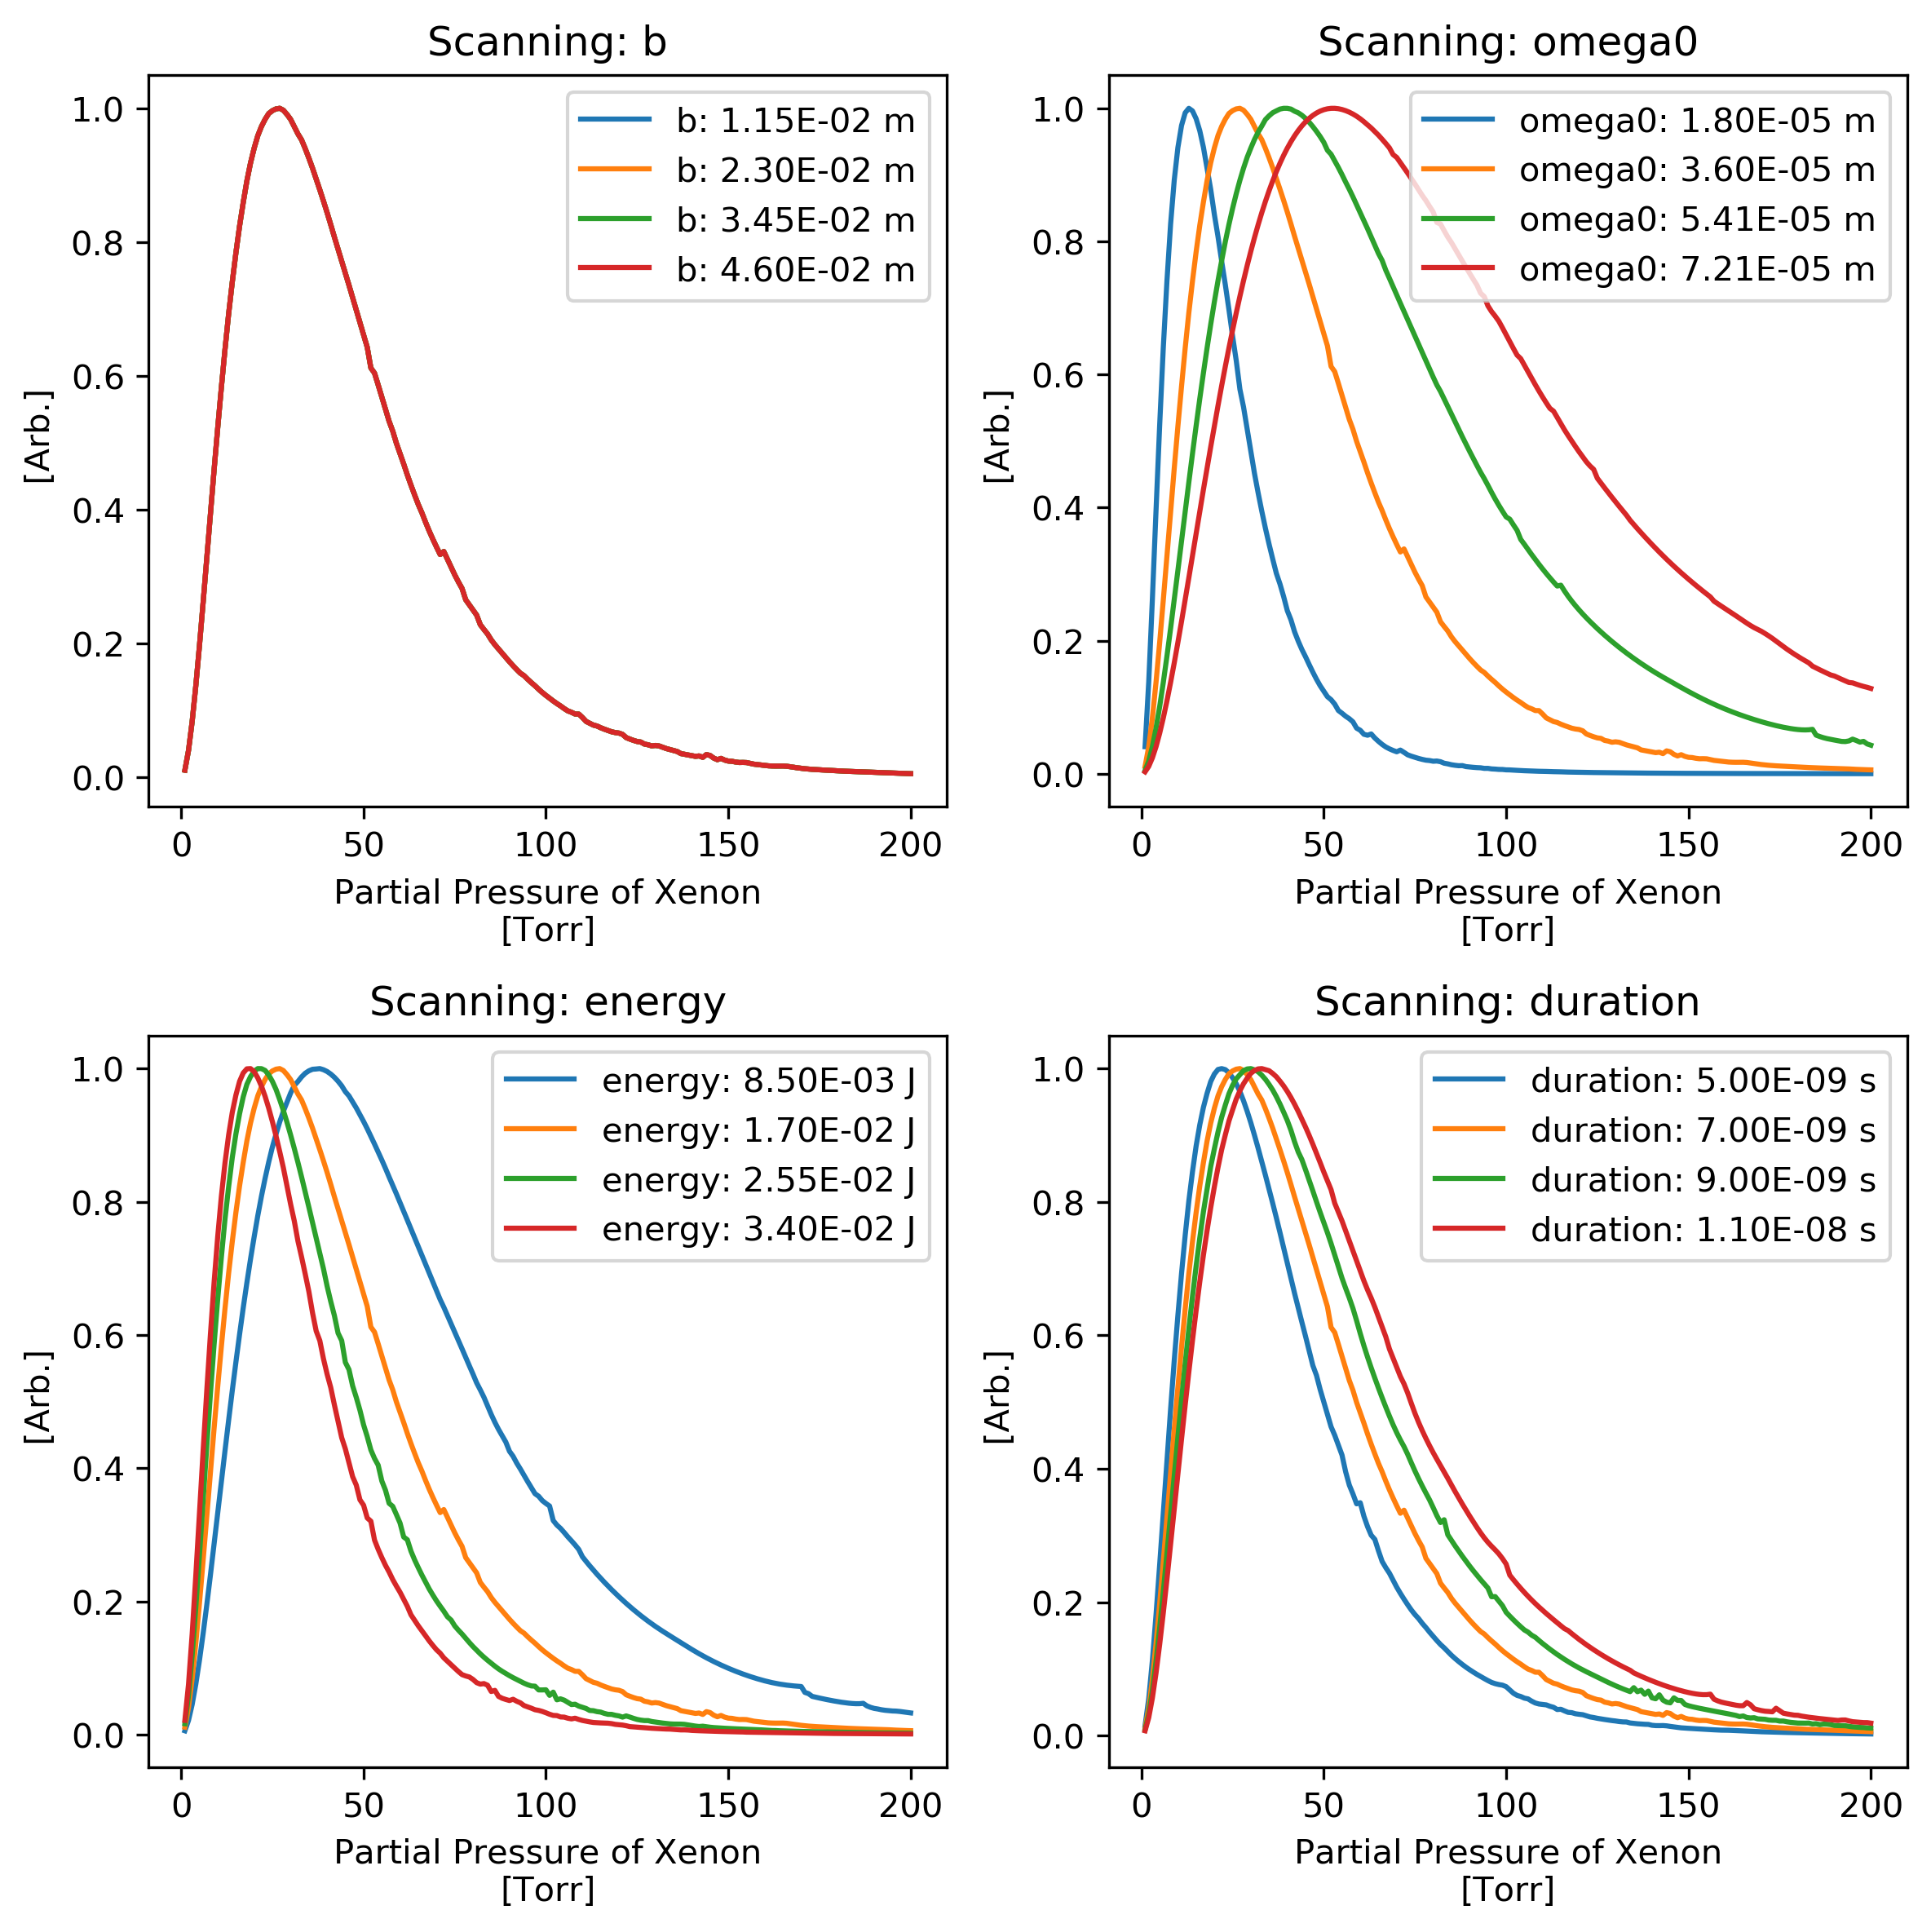

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), dpi=300)
ax = ax.flatten()
plot_single_1D_scan(b_scanned, ax[0], selections={'variable': '118 signal'})
plot_single_1D_scan(omega_scanned, ax[1], selections={'variable': '118 signal'})
plot_single_1D_scan(E_scanned, ax[2], selections={'variable': '118 signal'})
plot_single_1D_scan(dt_scanned, ax[3], selections={'variable': '118 signal'})
plt.tight_layout()

This is a lot of data to try and process. However, it roughly looks like all of the data has the same functional form. We can verify this by scaling the x and y coordinates of the data, and see if we can make the plots overlap.

In [32]:
def plot_single_1D_scan_scaled(data, x_scaling, y_scaling, ax, selections=None, norm=True):
    scan_var = data.dims[0]
    
    for val, x, y in zip(data.coords[scan_var], x_scaling, y_scaling):
        label = f"{scan_var}: {val.data:.2E} {val.attrs['units']}"
        sel = {scan_var: val, **selections}
        sel_data = data.sel(sel)
        scaled_x = sel_data.coords['PXe'].data*x
        scaled_y = sel_data.data*y
        ax.plot(scaled_x[scaled_x<80], scaled_y[scaled_x<80], label=label)
    ax.set_title(f"Scaled Scan of: {scan_var} {selections['variable']}")
    ax.legend()

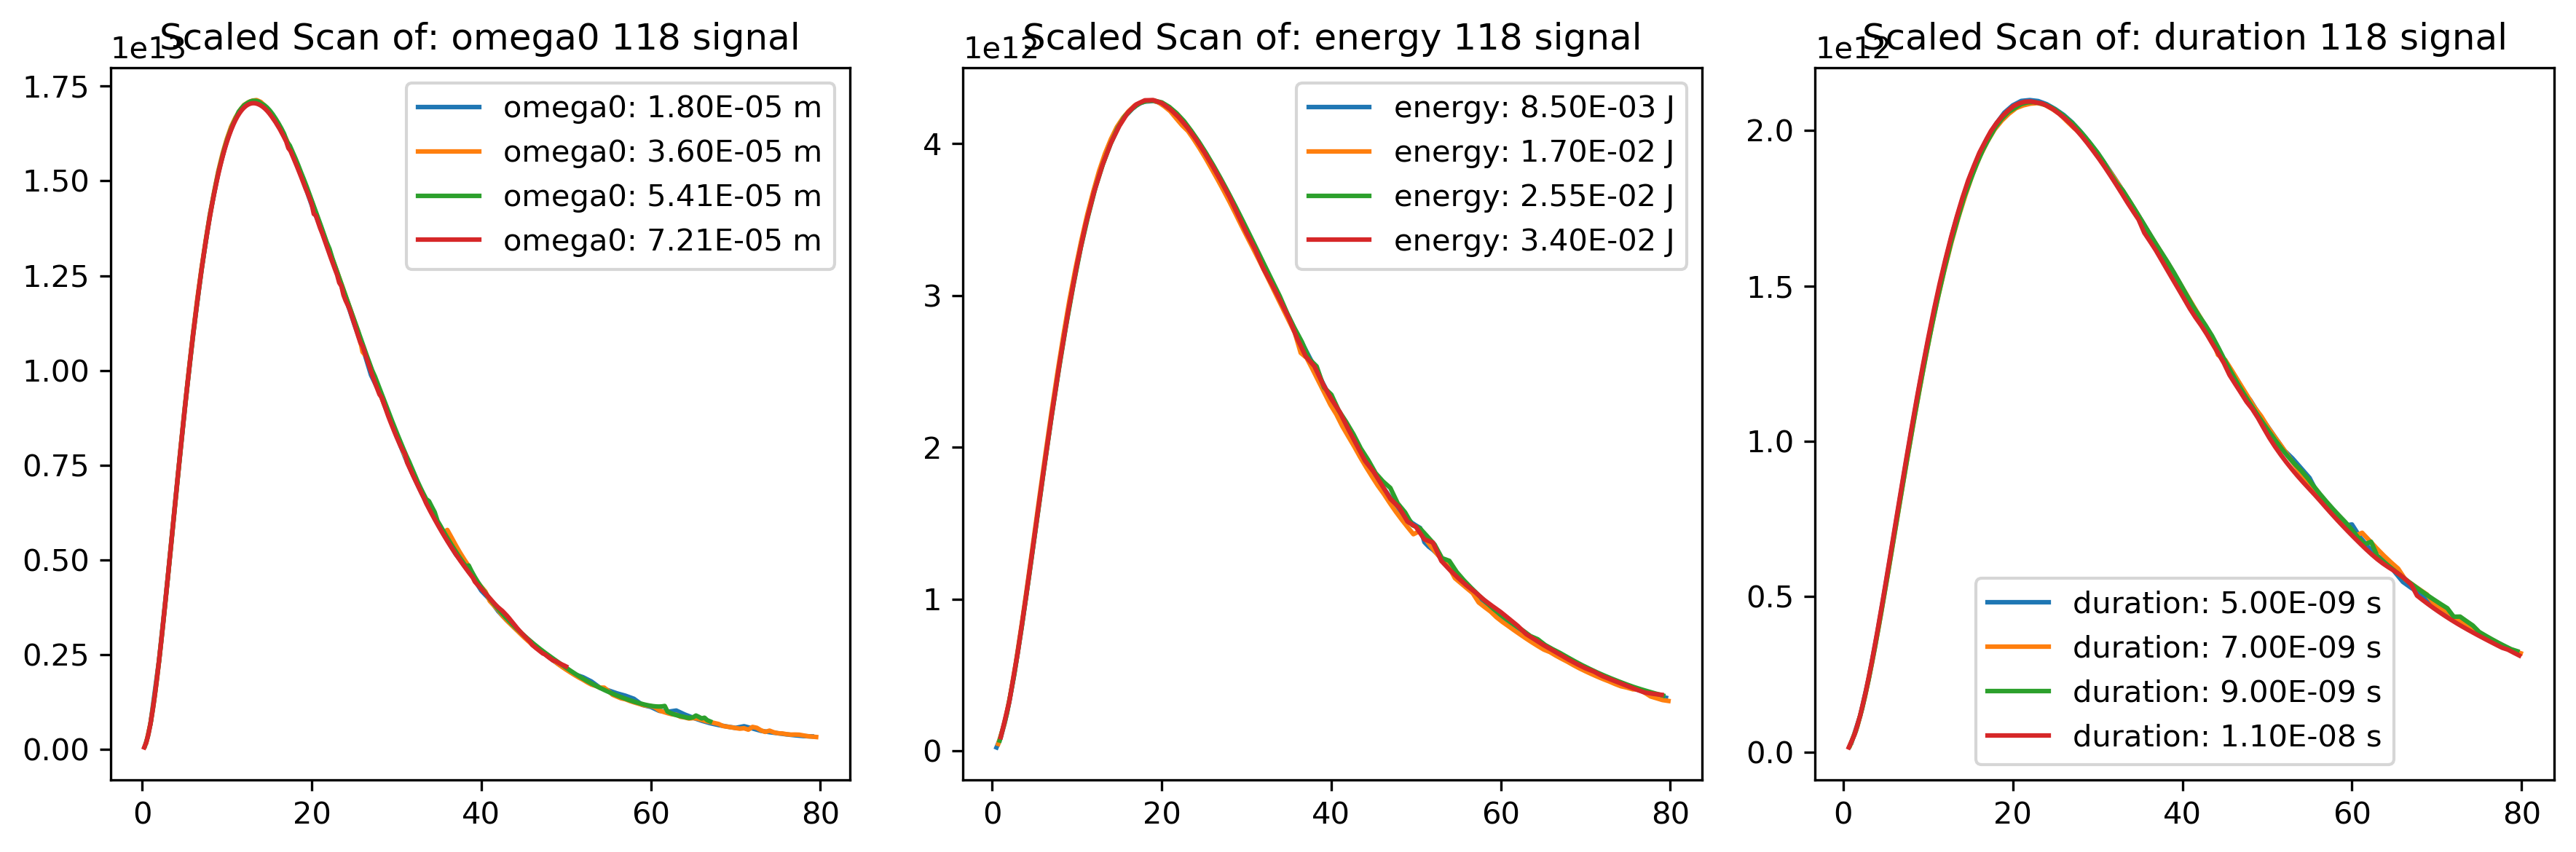

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), dpi=300)
ax = ax.flatten()

omega_x_scaling = (1, .5, .335, .25)
omega_y_scaling = (1, 16, 81, 255)
plot_single_1D_scan_scaled(omega_scanned, omega_x_scaling, omega_y_scaling,
                           ax[0], selections={'variable': '118 signal'})

E_x_scaling = (.5, .7, .87, 1)
E_y_scaling = (16, 4, 1.78, 1)
plot_single_1D_scan_scaled(E_scanned, E_x_scaling, E_y_scaling,
                           ax[1], selections={'variable': '118 signal'})

dt_x_scaling = (1, .85, .75, .67)
dt_y_scaling = (1, 1.95, 3.23, 4.83)
plot_single_1D_scan_scaled(dt_scanned, dt_x_scaling, dt_y_scaling,
                           ax[2], selections={'variable': '118 signal'})
    
plt.tight_layout()
plt.show()

This shows that changing any of the pulse parameters only changes the scaling of the signal, not the functional form. To find a better functional fit, we must rely on changing the harmonic generation parameters and function.

First we will investigate how changing the harmonic generation parameters affects the scaling and functional form for each loss function independantly. The first step is to find reasonable los parameters for each of the different processes so that the 118 signal has a peak at roughly 24 Torr for each loss process.

### Scanning Chis

In [34]:
#chi3s = np.linspace(chi3/10000, chi3*10000, 5)
chi3s = chi3 * np.power(10,np.linspace(-2, 2, 5))
chi3_scan = xr.DataArray(chi3s,
                     dims = ('chi3'),
                     attrs = {'units': 'm^2/V^2',
                              'long_name': "chi3 of xenon"})
chi3_scanned = scan_builder(single_func, default_params, [Pscan, chi3_scan])(params=default_params)

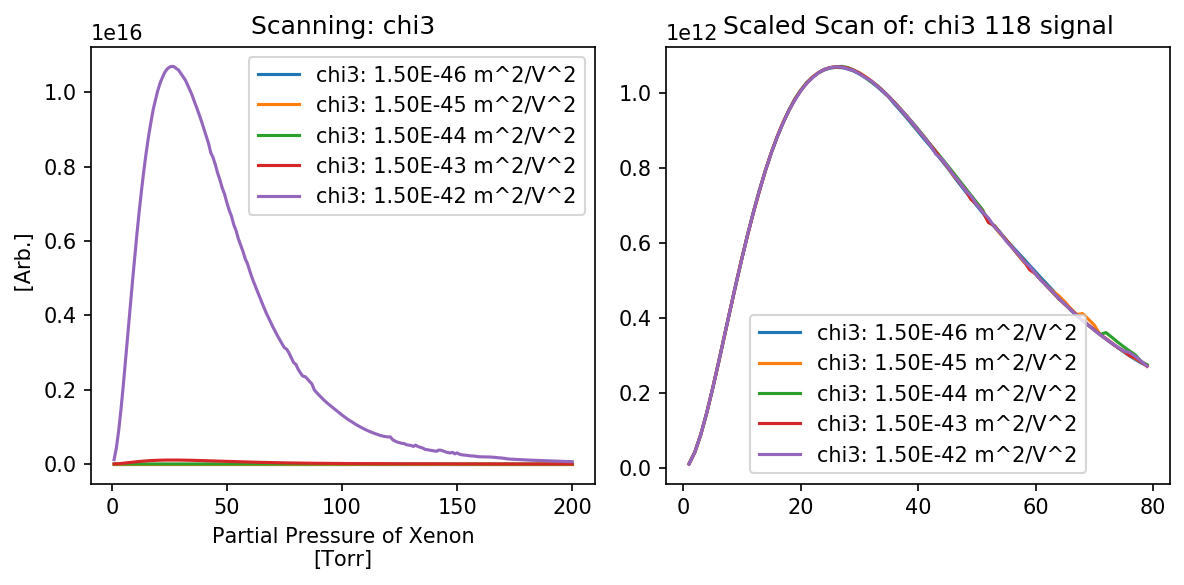

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=150)
plot_single_1D_scan(chi3_scanned, ax[0], selections={'variable': '118 signal'}, norm=False)

chi3_x_scaling = (1, 1, 1, 1, 1)
chi3_y_scaling = (10000, 100, 1, .01, .0001)

plot_single_1D_scan_scaled(chi3_scanned, chi3_x_scaling, chi3_y_scaling,
                           ax[1], selections={'variable': '118 signal'})
plt.tight_layout()

We can change the `chi3` parameter and it also only changes the scaling in the amplitude. Interestingly, the amplitude of the 118 nm scales as the square of the change in the `chi3` parameter.

In [36]:
chi2s = chi2 * np.power(10,np.linspace(-1, 1, 5))
chi2_scan = xr.DataArray(chi2s,
                     dims = ('sigma'),
                     attrs = {'units': 'variable',
                              'long_name': "chi2 of xenon"})
chi2_scanned = scan_builder(single_func, default_params, [Pscan, chi2_scan])(params=default_params)

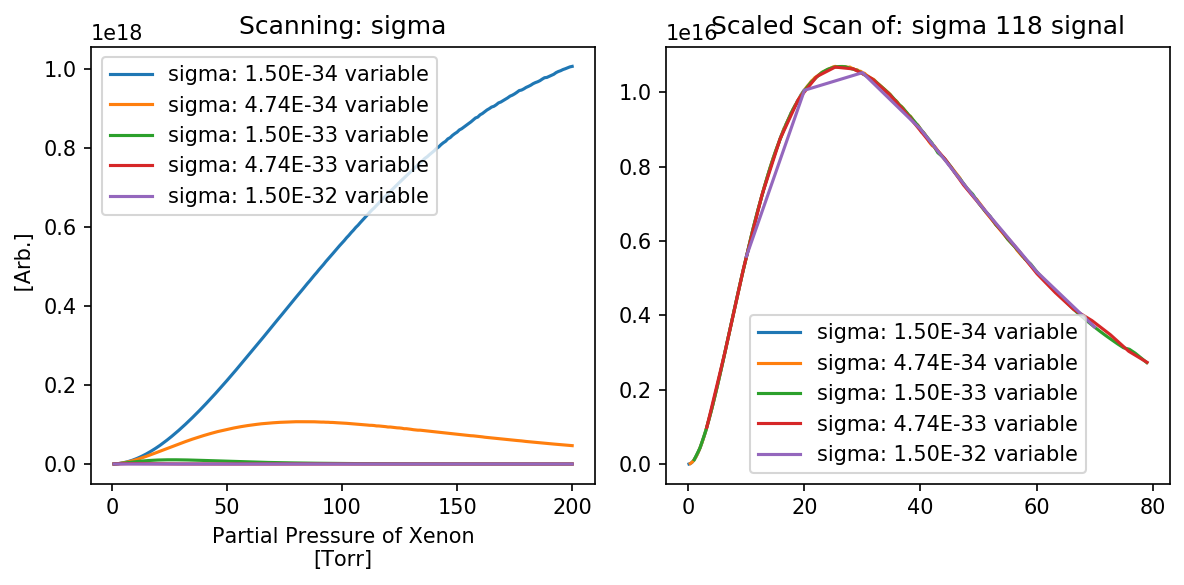

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

plot_single_1D_scan(chi2_scanned, ax[0], selections={'variable': '118 signal'}, norm=False)

chi2_x_scaling = (.1, 1/np.sqrt(10), 1, np.sqrt(10), 10)
chi2_y_scaling = (.01, .1, 1, 10, 100)

plot_single_1D_scan_scaled(chi2_scanned, chi2_x_scaling, chi2_y_scaling,
                           ax[1], selections={'variable': '118 signal'})
plt.tight_layout()

The `chi2` or `sigma` parameter also only affects the scaling of the amplitudes. Interestingly, the x-scaling is the square-root of the change in `chi2`, and the y-scaling is the square of the change in `chi2`. It is cool that these relationships are so cut and dry, but I'm not entirely sure what it means.

## Scanning Functional Form

Finally, we can vary the functional form of our differential equation. This should give us a change in the functional form!

### 2-photon harmonic process

In [38]:
sigma_2photon_Ar = 1.5E-33
sigma_2photon_Kr = 2.2E-33

photon2_params = {'b' : b,            # [m] confocal parameter
                  'zR' : zR,           # [m] Rayleigh range
                  'omega0' : omega0,   # [m] beam waist at focus
                  'energy' : 0.017,       # [J] single pulse energy
                  'duration' : 7e-9,     # [s] single pulse length

                  'sigma' : sigma_2photon_Ar,
                  'chi3' : chi3,
                  'PXe' : PXe,

                  'fluor_detect_window': (-0.1, 0.1),
                  'func': "dAmplitudes_dz_2_photon"
                  }

In [39]:
photon2_scanned = scan_builder(single_func, photon2_params, [Pscan])(params=photon2_params)

### 1+1' REMPI, pseudo first order with saturated 355 nm pump

In [40]:
#sigma_1p1_Ar = 6.3E-37
#sigma_1p1_Kr = 1.4E-36

sigma_1p1_Ar = 6.0E-36
sigma_1p1_Kr = 1.8E-35

rempi_pseudo_params = {'b' : b,            # [m] confocal parameter
                  'zR' : zR,           # [m] Rayleigh range
                  'omega0' : omega0,   # [m] beam waist at focus
                  'energy' : 0.017,       # [J] single pulse energy
                  'duration' : 7e-9,     # [s] single pulse length

                  'sigma' : sigma_1p1_Ar,
                  'chi3' : chi3,
                  'PXe' : PXe,

                  'fluor_detect_window': (-0.1, 0.1),
                  'func': "dAmplitudes_dz_1p1_REMPI"
                  }

In [41]:
rempi_pseudo_scanned = scan_builder(single_func, rempi_pseudo_params, [Pscan])(params=rempi_pseudo_params)

### 1+1' REMPI

In [42]:
#sigma_1p1_355_Ar = 6.0E-50
#sigma_1p1_355_Kr = 1.3E-49

sigma_1p1_355_Ar = 1.1E-43
sigma_1p1_355_Kr = 2.4E-43

rempi_1p1_params = {'b' : b,            # [m] confocal parameter
                  'zR' : zR,           # [m] Rayleigh range
                  'omega0' : omega0,   # [m] beam waist at focus
                  'energy' : 0.017,       # [J] single pulse energy
                  'duration' : 7e-9,     # [s] single pulse length

                  'sigma' : sigma_1p1_355_Ar,
                  'chi3' : chi3,
                  'PXe' : PXe,

                  'fluor_detect_window': (-0.1, 0.1),
                  'func': "dAmplitudes_dz_1p1_REMPI_355"
                  }

In [43]:
rempi_1p1_scanned = scan_builder(single_func, rempi_1p1_params, [Pscan])(params=rempi_1p1_params)

[]

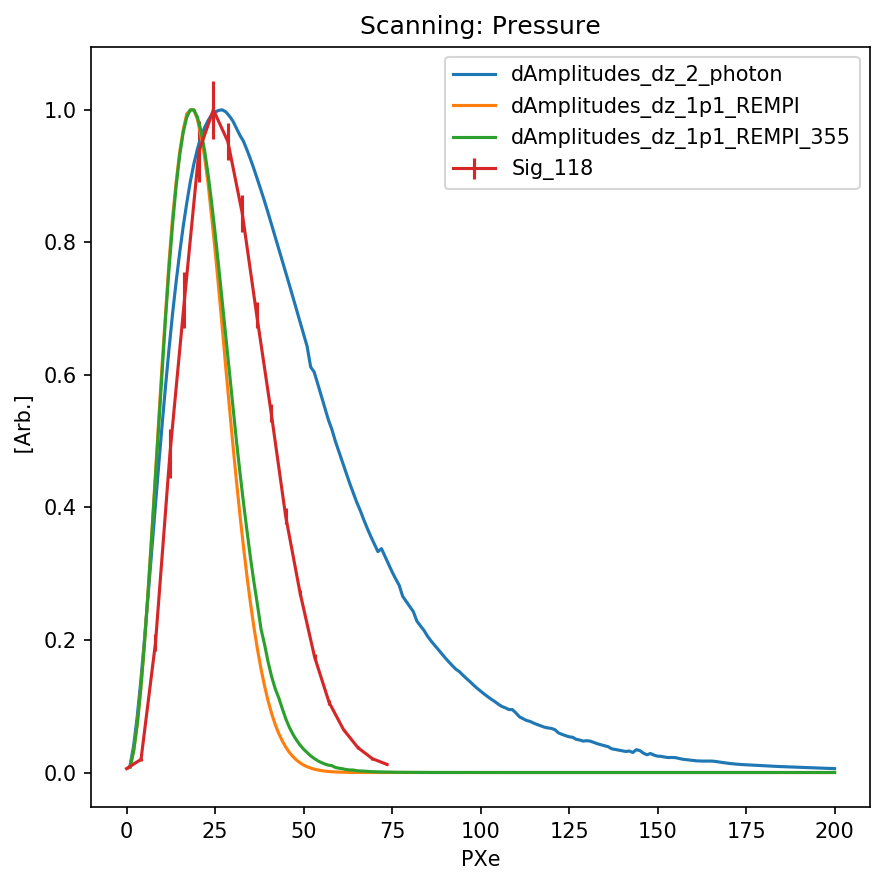

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=150)

def plot_pressure_scan(data, ax, selections=None, norm=True):
    sel = {**selections}
    if norm:
        norm_DataArray(data.sel(sel)).plot(ax=ax, label=data.attrs["func"])
    else:
        data.sel(sel).plot(ax=ax, label=data.attrs["func"])
    ax.set_title(f"Scanning: Pressure")
    ax.legend()


plot_pressure_scan(photon2_scanned, ax, selections={'variable': '118 signal'})
plot_pressure_scan(rempi_pseudo_scanned, ax, selections={'variable': '118 signal'})
plot_pressure_scan(rempi_1p1_scanned, ax, selections={'variable': '118 signal'})
    
data = plot_params[0][0]
data.plot(x='PXe', y='Sig_118', yerr='Sig_118_Err', ax=ax)
    
plt.tight_layout()
plt.plot()

And BOOM! The 1+1' REMPI processes match the experimental data much better than the 2-photon harmonic generation process does!

## Fitting

By eye, we have a good functional fit, but we can do better by actually fitting the pseudo-first-order (Beer's Law) differential equation to the experimental data for both argon and krypton.

In [45]:
def sigma_fit_func(x, sigma):
    rempi_pseudo_params['sigma'] = sigma
    scanned = scan_builder(single_func, rempi_pseudo_params, [Pscan_fit])(params=rempi_pseudo_params)
    return norm_DataArray(scanned.sel({'variable': '118 signal'})).values

In [46]:
xdata_Ar = plot_params[0][0].PXe.values
ydata_Ar = plot_params[0][0].Sig_118.values
yerr_Ar = plot_params[0][0].Sig_118_Err.values

Pscan_fit = xr.DataArray(xdata_Ar, 
                     dims = ('PXe'), 
                     attrs = {'units': 'Torr',
                              'long_name': "Partial Pressure of Xenon"})

popt_Ar, pcov_Ar = curve_fit(sigma_fit_func, xdata_Ar, ydata_Ar, p0=6.0E-36, sigma=yerr_Ar)
print(popt_Ar)

[2.91611415e-36]


In [47]:
xdata_Kr = plot_params[1][0].PXe.values
ydata_Kr = plot_params[1][0].Sig_118.values
yerr_Kr = plot_params[1][0].Sig_118_Err.values

Pscan_fit = xr.DataArray(xdata_Kr, 
                     dims = ('PXe'), 
                     attrs = {'units': 'Torr',
                              'long_name': "Partial Pressure of Xenon"})

popt_Kr, pcov_Kr = curve_fit(sigma_fit_func, xdata_Kr, ydata_Kr, p0=9.0E-36, sigma=yerr_Kr)
print(popt_Kr)

[8.43032822e-36]


In [48]:
rempi_pseudo_params['sigma'] = popt_Ar[0]
scanned_Ar = scan_builder(single_func, rempi_pseudo_params, [Pscan])(params=rempi_pseudo_params)
rempi_pseudo_params['sigma'] = popt_Kr[0]
scanned_Kr = scan_builder(single_func, rempi_pseudo_params, [Pscan])(params=rempi_pseudo_params)

In [49]:
norm_val = np.max(scanned_Ar.sel({'variable': '118 signal'}))
scanned_Ar_norm = scanned_Ar/norm_val
scanned_Kr_norm = scanned_Kr/norm_val

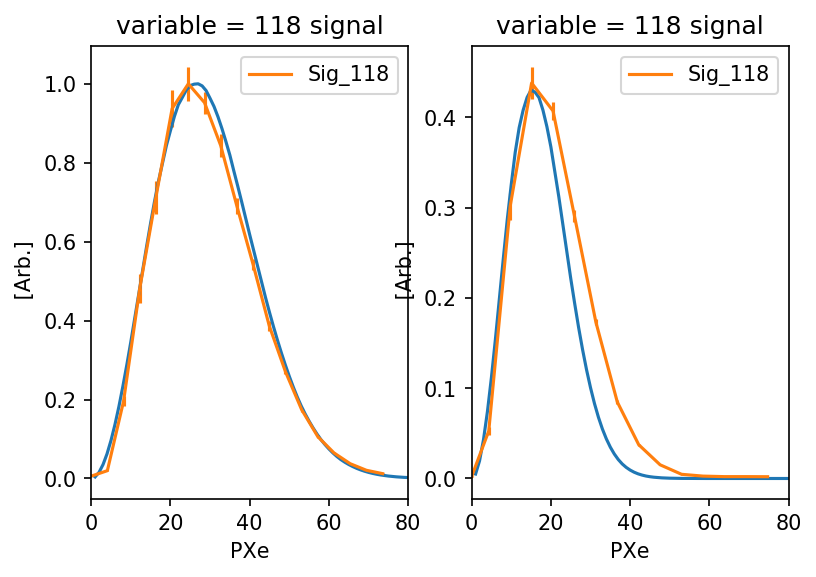

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(6,4), dpi=150)
norm_DataArray(scanned_Ar.sel({'variable': '118 signal'})).plot(ax=ax[0], label="Ar")
(norm_DataArray(scanned_Kr.sel({'variable': '118 signal'}))*.43).plot(ax=ax[1], label="Kr")

data = plot_params[0][0]
data.plot(x='PXe', y='Sig_118', yerr='Sig_118_Err', ax=ax[0])

data = plot_params[1][0]
data.plot(x='PXe', y='Sig_118', yerr='Sig_118_Err', ax=ax[1])

ax[0].set_xlim([0,80])
ax[1].set_xlim([0,80])
plt.show()

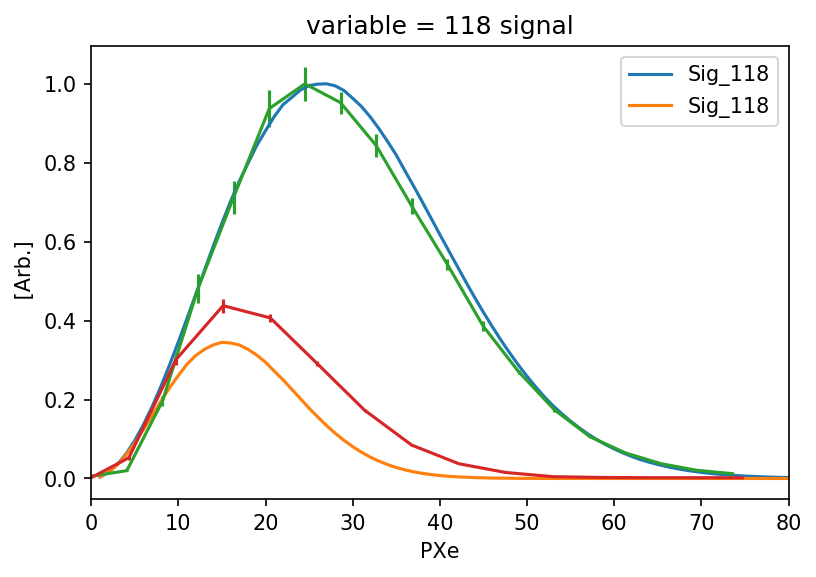

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=150)
scanned_Ar_norm.sel({'variable': '118 signal'}).plot(ax=ax, label="Ar")
scanned_Kr_norm.sel({'variable': '118 signal'}).plot(ax=ax, label="Kr")

data = plot_params[0][0]
data.plot(x='PXe', y='Sig_118', yerr='Sig_118_Err', ax=ax)

data = plot_params[1][0]
data.plot(x='PXe', y='Sig_118', yerr='Sig_118_Err', ax=ax)

ax.set_xlim([0,80])
plt.show()

In [52]:
scanned_Ar_norm.attrs

{'b': 0.023,
 'zR': 0.0115,
 'omega0': 3.604857986586053e-05,
 'energy': 0.017,
 'duration': 7e-09,
 'sigma': 2.916114153440235e-36,
 'chi3': 1.5e-44,
 'fluor_detect_window': (-0.1, 0.1),
 'func': 'dAmplitudes_dz_1p1_REMPI',
 'units': 'Arb.',
 'zrange': (-0.2, 0.2),
 'init_vals': [1e-10, 1e-10, 1e-10],
 't_eval': array([-0.2       , -0.1959596 , -0.19191919, -0.18787879, -0.18383838,
        -0.17979798, -0.17575758, -0.17171717, -0.16767677, -0.16363636,
        -0.15959596, -0.15555556, -0.15151515, -0.14747475, -0.14343434,
        -0.13939394, -0.13535354, -0.13131313, -0.12727273, -0.12323232,
        -0.11919192, -0.11515152, -0.11111111, -0.10707071, -0.1030303 ,
        -0.0989899 , -0.09494949, -0.09090909, -0.08686869, -0.08282828,
        -0.07878788, -0.07474747, -0.07070707, -0.06666667, -0.06262626,
        -0.05858586, -0.05454545, -0.05050505, -0.04646465, -0.04242424,
        -0.03838384, -0.03434343, -0.03030303, -0.02626263, -0.02222222,
        -0.01818182, -0.01414

## Conclusions

https://www.osapublishing.org/josa/abstract.cfm?uri=josa-69-1-159

The fitted value of `sigma` of $2.915 \times 10^{-36}$ matches INCREDIBLY well with our theoretically calculated version for a 1-photon absorption of 118 nm light into xenon, followed by a saturated transition from the excited state of $1.958 \times 10^{-36} cm^5$!!!

The difference between those two values is probably due to other effects that the 1-photon absorptionn model does not address, such as effect of the xenon ions on the absorption linewidth.

This reasoning applies to the krypton data as well: the experimentally extracted `sigma` of $8.459 \times 10^{-36}$ is roughly three times larger than that of argon because the krypton atoms are playing a role in the loss process. Most likely, they are being ionized by the xenon plasma and are contributing to the broadening of the 118 absorption lines.